In [2]:
import pandas as pd
import yfinance as yf
import datetime as dt
import numpy as np
import itertools
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats as sc
import pandas_datareader.data as pdr

## Read ESG Data and Create Portfolios

In [3]:
esg_data= pd.read_csv("H:/My Drive/Projects/ESG_Momentum_Strategy/Data/ESG_Data_Yearly.csv")
# esg_data.sort_values(by=['ESG Disc Score','Mkt Cap'],ascending=False,inplace=True)
year_group=esg_data.groupby(by='YEAR')

In [4]:
#Portfolio Creation using ESG
port_size = 50
port_stks_high_esg = pd.DataFrame()
port_stks_low_esg = pd.DataFrame()
for i in range(2010,2021):
    temp = year_group.get_group(i)
    temp.sort_values(by='ESG_DISC_SCORE',ascending=True,inplace=True)
    temp_len = len(temp)
    port_stks_high_esg[i] = [s for s in temp['ID'][temp_len-port_size:]]
    port_stks_low_esg[i] = [s for s in temp['ID'][:port_size]]



C:\Users\siddh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [15]:
# stocks we need the data for from the master STOCK_PRICE file. 
stks_needed_1 = [item for t in port_stks_high_esg.values.tolist() for item in t]
stks_needed_2 = [item for t in port_stks_low_esg.values.tolist() for item in t]
stks_needed = set(stks_needed_1).union(set(stks_needed_2))
stks_needed = list(stks_needed)
stks_needed = [i.replace(" US Equity","") for i in stks_needed]
# stks_needed
# pd.DataFrame(list(stks_needed)).to_csv("Stocks_needed.csv")

## Create Stock Price Data (Not needed to run each time)

In [50]:
##Remove tickers for which there is no data avaialble 
stks_needed.remove('JCS')
port_stks_high_esg.replace("JCS US Equity",np.nan)
port_stks_high_esg.fillna(method='ffill',inplace=True)
port_stks_low_esg.replace("JCS US Equity",np.nan)
port_stks_low_esg.fillna(method='ffill',inplace=True)

In [ ]:

#Create the stock price database 
st_date = dt.datetime(2010,1,1)
en_date = dt.datetime(2020,12,31)
Stk_prices_list = []
flag = 0
tc_list = []

for tc in list(stks_needed):
    if flag ==0 : 
        flag =1 
        Stk_prices_list.append(pdr.DataReader(tc, 'yahoo', start=st_date, end=en_date)['Adj Close'].index)
        tc_list.append('Date')
    Stk_prices_list.append(pdr.DataReader(tc, 'yahoo', start=st_date, end=en_date)['Adj Close'].tolist())
    tc_list.append(tc)

Stk_prices_list=list(map(list, itertools.zip_longest(*Stk_prices_list, fillvalue=None)))
Stock_prices = pd.DataFrame(Stk_prices_list,columns=tc_list)
# Stock_prices.set_index('Date',inplace=True)

#Create Database of stock prices
# Stock_prices.to_csv("STOCK_PRICE_CLOSE.csv")        

## Read Stock Prices from file

In [5]:
#read from Stock prices database
Stock_prices = pd.read_csv("H:/My Drive/Projects/ESG_Momentum_Strategy/STOCK_PRICE_CLOSE.csv",index_col='Date')
# Stock_prices.drop('Unnamed: 0',axis= 1,inplace=True)
Stock_prices.fillna(method='ffill',inplace=True)
Stock_prices.index = pd.to_datetime(Stock_prices.index)
Stock_returns = Stock_prices.pct_change()


## Create Momentum Portfolios

In [6]:
Mom_HESG_Buy_portfolio = []
Mom_HESG_Sell_portfolio = []
Mom_LESG_Buy_portfolio = []
Mom_LESG_Sell_portfolio = []

Mom_Port_length = 10

#Create Date Ranges of observation periods 
# Assume first observation period starts from 04-01-2010
Observation_start_date = dt.datetime(2010,4,1)
Obs_per_st_dates = [Observation_start_date + pd.DateOffset(months=3*i) for i in range(45)]
Dates = Stock_returns.index
Obs_per_date_ranges = []

Dates = Dates[Dates>=Observation_start_date]
for per_st in Obs_per_st_dates[1:]:
    Obs_per_date_ranges.append(Dates[Dates<=per_st].tolist())
    Dates = Dates[Dates>per_st]

toggle = 0
for port in [port_stks_high_esg,port_stks_low_esg]:
    for rng in Obs_per_date_ranges:
        year = rng[0].year
        if rng[0].month<3 and year > 2010:
            year = year -1 
        tc_dict={}
        for tc in port[year]:
            c = tc.replace(' US Equity','')
            ret = Stock_returns[c][rng]
            ret = [1+i for i in ret]
            tc_dict[c] = np.prod(ret)
        #get the 10 highest/lowest return tciekrs and add to buy/sell portfolio    
        temp_list = sorted(tc_dict , key = tc_dict.get,reverse=True)
        if toggle == 0:
            Mom_HESG_Buy_portfolio.append(temp_list[:Mom_Port_length])
            Mom_HESG_Sell_portfolio.append(temp_list[-Mom_Port_length:])
        else:
            Mom_LESG_Buy_portfolio.append(temp_list[:Mom_Port_length])
            Mom_LESG_Sell_portfolio.append(temp_list[-Mom_Port_length:])
    toggle = 1


In [59]:
#Calculate daily returns for the momentum strategy portfolios 

Scalar = 1/(2*Mom_Port_length)
Mom_HESG_Returns = []
Mom_LESG_Returns = []
Dates_index  = [i for j in Obs_per_date_ranges for i in j]

#HIGH ESG PORTFOLIO
for i in range(1,len(Obs_per_date_ranges)):
    temp = [0]*len(Obs_per_date_ranges[i])
    for tc in range(Mom_Port_length):
        for k in range(len(Obs_per_date_ranges[i])):
            # print(Stock_returns[Mom_HESG_Buy_portfolio[i][tc]][Obs_per_date_ranges[i][k]], i, k , tc)
            temp_high_rets= Stock_returns[Mom_HESG_Buy_portfolio[i-1][tc]][Obs_per_date_ranges[i][k]]
            temp_low_rets= Stock_returns[Mom_HESG_Sell_portfolio[i-1][tc]][Obs_per_date_ranges[i][k]]
            temp[k] = temp[k] + ((temp_low_rets-temp_high_rets)*Scalar)
    Mom_HESG_Returns.append(temp)
Mom_HESG_Returns = [Mom_HESG_Returns[i][j] for i in range(len(Mom_HESG_Returns)) for j in range(len(Mom_HESG_Returns[i]))]


#LoW ESG PORTFOLIO
for i in range(1,len(Obs_per_date_ranges)):
    temp = [0]*len(Obs_per_date_ranges[i])
    for tc in range(Mom_Port_length):
        for k in range(len(Obs_per_date_ranges[i])):
            # print(Stock_returns[Mom_HESG_Buy_portfolio[i][tc]][Obs_per_date_ranges[i][k]], i, k , tc)
            temp_high_rets= Stock_returns[Mom_LESG_Buy_portfolio[i-1][tc]][Obs_per_date_ranges[i][k]]
            temp_low_rets= Stock_returns[Mom_LESG_Sell_portfolio[i-1][tc]][Obs_per_date_ranges[i][k]]
            temp[k] = temp[k] + ((temp_low_rets-temp_high_rets)*Scalar)
    Mom_LESG_Returns.append(temp)
Mom_LESG_Returns = [Mom_LESG_Returns[i][j] for i in range(len(Mom_LESG_Returns)) for j in range(len(Mom_LESG_Returns[i]))]

Mom_Returns = pd.DataFrame(list(zip(Mom_HESG_Returns,Mom_LESG_Returns)),columns=['HIGHESG','LOWESG'],index=Dates_index)

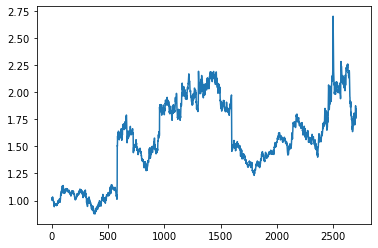

In [65]:
t = [1+i for i in Mom_HESG_Returns]
t = np.cumprod(t)
plt.plot(t)

s = [1+i for i in Mom_HESG_Returns]
s = np.cumprod(t)
plt.plot(t)

## Calculate Portfolio Returns 

In [10]:
#ESG portfolios - Static
#Calculate the daily returns for ESG portfolios 
Dates = Stock_returns.index
Dates_len = len(Dates)
port_ret_high = []
port_ret_low = []

#initialize dataframe of len dates
# Loop over different portfolios and calcualte the daily returns for them 
toggle = 0
for port in [port_stks_high_esg,port_stks_low_esg]:
    for i in Dates[1:]:
        #debug conditoin
        if i.year == 2021:
            break
        temp = 0.0

        for j in port[i.year]:
            temp = temp + Stock_returns[j.replace(' US Equity','')][i] * 0.02
        
        if toggle == 0:
            port_ret_high.append(temp)
        else:
            port_ret_low.append(temp)
    toggle = 1
port_ret_high_esg = pd.DataFrame(port_ret_high,index=Dates[:len(Dates)-252],columns=['Returns'])
port_ret_low_esg = pd.DataFrame(port_ret_low,index=Dates[:len(Dates)-252],columns=['Returns'])


port_ret_high_esg.to_csv("Port_high_ret_daily.csv")
port_ret_low_esg.to_csv("Port_low_ret_daily.csv")


## Fama French Model Fitting

In [11]:
#Read FF factors 
ff_factors = pd.read_csv("H:/My Drive/Projects/ESG_Momentum_Strategy/Data/Fama_French_Factors.csv",index_col="date",parse_dates=['date'])
ff_factors.head()

#Create a dataframe of fama frenchfactors and our returns 
mkt_rf = []
smb = []
hml = []
rf = []
for i in port_ret_high_esg.index:
    mkt_rf.append(ff_factors['Mkt-RF'][i])
    smb.append(ff_factors['SMB'][i])
    hml.append(ff_factors['HML'][i])
    rf.append(ff_factors['RF'][i])

fama_french_factors = pd.DataFrame(list(zip(mkt_rf,smb,hml)),columns=['MKT-RF',"SMB","HML"],index=port_ret_high_esg.index)



In [173]:
#High ESG portfolio
X = sm.add_constant(fama_french_factors[['MKT-RF',"SMB","HML"]])
model1 = sm.OLS(port_ret_high_esg['Returns'],X).fit()
model1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Returns   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     372.9
Date:                Wed, 23 Mar 2022   Prob (F-statistic):          2.42e-203
Time:                        19:33:30   Log-Likelihood:                 8858.8
No. Observations:                2768   AIC:                        -1.771e+04
Df Residuals:                    2764   BIC:                        -1.769e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.959      0.050    -2.5e-07       0.001
MKT-RF         0.0028      0.000     16.100      0.000       0.002       0.003
SMB            0.0073      0.000     21.240      0.000       0.007       0.008
HML            0.0025      0.000      8.846      0.000       0.002       0.003
==============================================================================
Omnibus:                      872.830   Durbin-Watson:                   2.382
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18706.598
Skew:                           0.970   Prob(JB):                         0.00
Kurtosis:                      15.587   Cond. No.                         2.13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [174]:
#Low ESG portfolio
model2 = sm.OLS(port_ret_low_esg['Returns'],X).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Returns   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     5.709
Date:                Wed, 23 Mar 2022   Prob (F-statistic):           0.000682
Time:                        19:35:39   Log-Likelihood:                 4735.6
No. Observations:                2768   AIC:                            -9463.
Df Residuals:                    2764   BIC:                            -9439.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0050      0.001      5.939      0.000       0.003       0.007
MKT-RF         0.0015      0.001      1.898      0.058   -4.91e-05       0.003
SMB            0.0046      0.002      3.039      0.002       0.002       0.008
HML            0.0002      0.001      0.132      0.895      -0.002       0.003
==============================================================================
Omnibus:                     6646.264   Durbin-Watson:                   2.095
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         78336955.663
Skew:                          24.033   Prob(JB):                         0.00
Kurtosis:                     825.746   Cond. No.                         2.13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

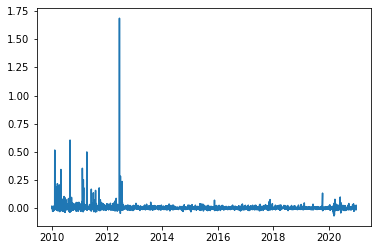

             Returns  Cum_Rets
Date                          
2010-01-04  0.005408  1.005408
2010-01-05  0.018687  1.018687
2010-01-06  0.012718  1.012718
2010-01-07 -0.006550  0.993450
2010-01-08  0.004161  1.004161
...              ...       ...
2020-12-23  0.012905  1.012905
2020-12-24 -0.009300  0.990700
2020-12-28 -0.005556  0.994444
2020-12-29 -0.016075  0.983925
2020-12-30  0.024011  1.024011

[2768 rows x 2 columns]


In [207]:
port_ret_high_esg["Cum_Rets"] = port_ret_high_esg["Returns"]+1
port_ret_low_esg["Cum_Rets"] = port_ret_low_esg["Returns"]+1
cum_rets_high_esg = port_ret_high_esg["Cum_Rets"].cumprod()
cum_rets_low_esg = port_ret_low_esg["Cum_Rets"].cumprod()

# plt.plot(cum_rets_high_esg)
# plt.plot(cum_rets_low_esg)
plt.plot(port_ret_low_esg['Returns'])
plt.show()
min(port_ret_low_esg['Returns'])
print(port_ret_low_esg)